## _Different Ways to Load Data_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

# local imports
from src import draw_event
from src import compose_event

## _Input Data_

In [6]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = '../train_all'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

### _(1) - Fetch all Files at Once_

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)
all_files[:10]

['event0000000958-truth.csv',
 'event0000000629-hits.csv',
 'event0000000374-particles.csv',
 'event0000000588-hits.csv',
 'event0000000483-cells.csv',
 'event0000000928-cells.csv',
 'event0000000698-truth.csv',
 'event0000000295-truth.csv',
 'event0000000640-particles.csv',
 'event0000000257-hits.csv']

In [8]:
# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, '')) for f in all_files if f.endswith(suffix))
file_prefixes[:10]

['../train_all/event0000000000',
 '../train_all/event0000000001',
 '../train_all/event0000000002',
 '../train_all/event0000000003',
 '../train_all/event0000000004',
 '../train_all/event0000000005',
 '../train_all/event0000000006',
 '../train_all/event0000000007',
 '../train_all/event0000000008',
 '../train_all/event0000000009']

In [9]:
# number of events
len(file_prefixes)

1000

In [10]:
# OR, Extract File Prefixes (only works if we don't have any additional files e.g. *.root, *.log etc.)
all_events = sorted(np.unique([os.path.join(input_dir, event[:15]) for event in all_files]))
all_events[:10]

['../train_all/event0000000000',
 '../train_all/event0000000001',
 '../train_all/event0000000002',
 '../train_all/event0000000003',
 '../train_all/event0000000004',
 '../train_all/event0000000005',
 '../train_all/event0000000006',
 '../train_all/event0000000007',
 '../train_all/event0000000008',
 '../train_all/event0000000009']

In [11]:
# number of events (in addition to *.csv, *.root and *.log files exists in this dir.)
len(all_events)

1009

In [12]:
event_id = 1

In [13]:
# OR, use event_id to fectch one file from list of all files
event_prefix = file_prefixes[event_id]
print(event_prefix)

../train_all/event0000000001


In [14]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [15]:
hits.head()

hit_id        x       y     z  volume_id  layer_id  module_id
0       1 -12.2456  12.120  35.0          9         0         12
1       2 -13.1203  12.625  35.0          9         1        117
2       3 -13.9950  13.130  35.0          9         2        228
3       4 -13.9950  14.140  35.0          9         3        344
4       5 -14.8697  14.645  35.0          9         4        467

In [16]:
tubes.head()

hit_id  isochrone   depcharge  energyloss  volume_id  layer_id  module_id  \
0       1   0.262386   6000300.0     6.00030          9         0         12   
1       2   0.052152  13722100.0    13.72210          9         1        117   
2       3   0.374347   4073350.0     4.07335          9         2        228   
3       4   0.265922   6590940.0     6.59094          9         3        344   
4       5   0.085074  11615800.0    11.61580          9         4        467   

   skewed  sector_id  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

In [17]:
particles.head()

particle_id   vx   vy   vz        px        py        pz  q  nhits  \
0            1  0.0  0.0  0.0 -0.134669  0.028540 -0.091022  1     25   
1            2  0.0  0.0  0.0 -0.550762 -0.441498  0.780609  1     24   
2            3  0.0  0.0  0.0 -0.072724  0.023378  0.175138  1     30   
3            4  0.0  0.0  0.0  0.936311 -0.311491 -1.019850  1     24   
4            5  0.0  0.0  0.0 -1.049040 -0.440627  0.471787  1     23   

   pdgcode  start_time  
0       13           0  
1       13           0  
2       13           0  
3       13           0  
4       13           0

In [18]:
truth.head()

hit_id       tx       ty       tz       tpx       tpy       tpz  weight  \
0       1 -12.4533  11.9370  18.0376 -0.208362  0.236490  0.330727     1.0   
1       2 -13.0823  12.6579  19.0411 -0.206470  0.238251  0.330621     1.0   
2       3 -13.7024  13.3791  20.0387 -0.204324  0.239940  0.330703     1.0   
3       4 -14.1996  13.9682  20.8477 -0.202521  0.241390  0.330725     1.0   
4       5 -14.8052  14.6980  21.8424 -0.200172  0.243415  0.330639     1.0   

   particle_id  
0           10  
1           10  
2           10  
3           10  
4           10

### _(2) - Fetch a Single Event_

In [19]:
event_id = 1

In [20]:
# Fetch an event, use event_id (int)
prefix = "event{:010d}".format(event_id)                     # OR, 
prefix = str('event{!s}'.format(format(event_id, '010d')))   # a little better
event_prefix = os.path.join(input_dir, prefix)              # event_prefix ~ event_file = input_dir + prefix

In [21]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))


event0000000001 memory usage 0.03 MB


In [22]:
hits.head()

hit_id        x       y     z  volume_id  layer_id  module_id
0       1 -12.2456  12.120  35.0          9         0         12
1       2 -13.1203  12.625  35.0          9         1        117
2       3 -13.9950  13.130  35.0          9         2        228
3       4 -13.9950  14.140  35.0          9         3        344
4       5 -14.8697  14.645  35.0          9         4        467

In [23]:
tubes.head()

hit_id  isochrone   depcharge  energyloss  volume_id  layer_id  module_id  \
0       1   0.262386   6000300.0     6.00030          9         0         12   
1       2   0.052152  13722100.0    13.72210          9         1        117   
2       3   0.374347   4073350.0     4.07335          9         2        228   
3       4   0.265922   6590940.0     6.59094          9         3        344   
4       5   0.085074  11615800.0    11.61580          9         4        467   

   skewed  sector_id  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

In [24]:
particles.head()

particle_id   vx   vy   vz        px        py        pz  q  nhits  \
0            1  0.0  0.0  0.0 -0.134669  0.028540 -0.091022  1     25   
1            2  0.0  0.0  0.0 -0.550762 -0.441498  0.780609  1     24   
2            3  0.0  0.0  0.0 -0.072724  0.023378  0.175138  1     30   
3            4  0.0  0.0  0.0  0.936311 -0.311491 -1.019850  1     24   
4            5  0.0  0.0  0.0 -1.049040 -0.440627  0.471787  1     23   

   pdgcode  start_time  
0       13           0  
1       13           0  
2       13           0  
3       13           0  
4       13           0

In [25]:
truth.head()

hit_id       tx       ty       tz       tpx       tpy       tpz  weight  \
0       1 -12.4533  11.9370  18.0376 -0.208362  0.236490  0.330727     1.0   
1       2 -13.0823  12.6579  19.0411 -0.206470  0.238251  0.330621     1.0   
2       3 -13.7024  13.3791  20.0387 -0.204324  0.239940  0.330703     1.0   
3       4 -14.1996  13.9682  20.8477 -0.202521  0.241390  0.330725     1.0   
4       5 -14.8052  14.6980  21.8424 -0.200172  0.243415  0.330639     1.0   

   particle_id  
0           10  
1           10  
2           10  
3           10  
4           10

## _Detector Layout_

In [26]:
event = compose_event(event_prefix,skewed=False)

In [27]:
event.head()

hit_id          x          y     z  volume_id  layer_id  module_id  \
0       1 -12.245600  12.120000  35.0          9         0         12   
1      26  16.618999   2.525000  35.0          9         0         81   
2      52 -13.995000 -11.110000  35.0          9         0         39   
3      73 -16.618999   7.575000  35.0          9         0         19   
4     102   2.624060  17.674999  35.0          9         0        104   

   isochrone  skewed  sector_id  ...       tpx       tpy       tpz  weight  \
0   0.262386       0          0  ... -0.208362  0.236490  0.330727     1.0   
1   0.493770       0          4  ...  0.260069  0.003329 -0.212996     1.0   
2   0.329479       0          2  ... -0.552770 -0.389080 -0.403564     1.0   
3   0.137127       0          1  ... -0.557918  0.276733  0.846760     1.0   
4   0.073398       0          5  ...  0.149280  0.802435  0.664844     1.0   

   particle_id   vx   vy   vz        pt  event_id  
0           10  0.0  0.0  0.0  0.315186         1  
1            9  0.0  0.0  0.0  0.260090         1  
2            8  0.0  0.0  0.0  0.675972         1  
3            7  0.0  0.0  0.0  0.622779         1  
4            6  0.0  0.0  0.0  0.816202         1  

[5 rows x 26 columns]

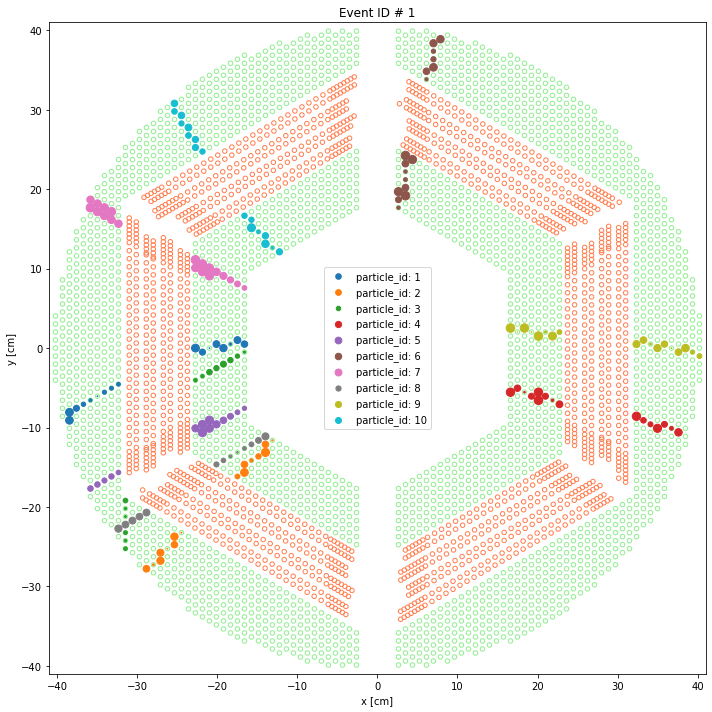

In [28]:
draw_event(event,figsize=(10, 10));